In [384]:
from PIL import Image
import numpy as np
from matplotlib.pyplot import imshow,show
import matplotlib.pyplot as plt
from datetime import datetime
import multiprocessing
from scipy.stats import kurtosis, skew
import statsmodels.api as sm
from sklearn.decomposition import PCA
%matplotlib inline

In [385]:
def getBorderIndexUtil(N):
    n=int(np.random.uniform(0,4*N-4))
    if n<N:return (n,0)
    elif n<=2*N-1:return (N-1,n-N)
    elif n<=3*N-2:return (3*N-n-1,N-1)
    else : return (0,4*N-n-3)

In [386]:
def getBorderIndex(k,l):
    N=l-k+1
    tempInd=getBorderIndexUtil(N)
    newInd=(tempInd[0]+k,tempInd[1]+k)
    return newInd

In [387]:
def getNewIndexUtil(index,N):
        direction=int(np.random.uniform(0,4))
        if direction==0: return (index+np.asarray([0,1]))%N
        elif direction==1: return (index+np.asarray([0,-1]))%N
        elif direction==2:return (index+np.asarray([-1,0]))%N
        elif direction==3:return (index+np.asarray([1,0]))%N

In [388]:
def getNewIndex(index,N,k,l):
        return getNewIndexUtil(index-np.asarray([k,k]),l-k+1)+np.asarray([k,k])

In [389]:
def update(arr,index,N,p,k,l):
    while True:
        newindex=getNewIndex(index,N,k,l)
        if arr[newindex[0]][newindex[1]]==0.0:
            index=newindex
            continue
        elif (arr[newindex[0]][newindex[1]]==1.0) and np.random.uniform(0,1)<p:
            arr[index[0]][index[1]]=1.0
            return arr
        else:
            continue

In [390]:
def getMinimalSquare(arr,N):
    totalSum=np.sum(arr)
    for ind in range(2,N//2):
        leftInd=(N//2-ind)
        rightInd=N//2+ind
        if (totalSum>np.sum(arr[leftInd+1:rightInd,leftInd+1:rightInd])):
             continue
        else:
             return (leftInd,rightInd)
    return (0,N-1)

In [391]:
def getLdaSimulation(p):
    N=501
    K=50000
    arr = np.zeros((N,N))
    arr[N//2][N//2]=1
    for x in range(K):
        k,l=getMinimalSquare(arr,N)
        print(p,x)
        index=np.asarray(getBorderIndex(k,l))
        arr=update(arr,index,N,p,k,l)
        if x%10000==0:np.save('locus_simulations/sim_'+str(x)+'_'+str(p),arr,allow_pickle=True)
    np.save('locus_simulations/sim_'+str(p),arr,allow_pickle=True)
    return arr    

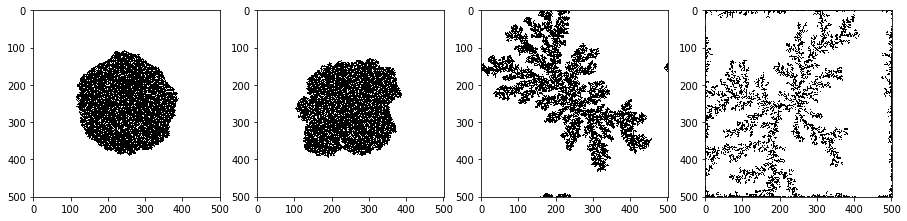

In [422]:
#pool = multiprocessing.Pool()
#result=pool.map(getLdaSimulation, [float(x)/1000 for x in range(1,51)])
#print (result)
columns=50
plt.figure(figsize=(200,100))
i=0
for p in [0.001,0.01,0.1,1.0]:
    arr=np.load('locus_simulations/sim_'+str(p)+'.npy',allow_pickle=True)
    plt.subplot(500 / columns + 1, columns, i + 1)
    plt.imshow(((arr+1)%2)*255,cmap='gray', vmin=0, vmax=255)
    i+=1
show()
    
    

In [393]:
def getOpenNeighbors(arr,N):
    sum=0.0
    k=0
    for i in range(N):
        for j in range(N):
            if arr[i][j]==0:
                continue
            else:
                sum+=4-(arr[(i+1)%N][j]+arr[(i-1)%N][j]+arr[i][(j-1)%N]+arr[i][(j+1)%N])
                k+=1
    return sum/k   

In [394]:
def getDensityVariance(arr,N):
    densitylist=[]
    for j in range(1,N//2):
        currarr=arr[(N//2)-j:(N//2)+j+1,(N//2)-j:(N//2)+j+1]
        prevarr=arr[(N//2)-j+1:(N//2)+j,(N//2)-j+1:(N//2)+j]
        area=(2*j+1)**2-(2*j-1)**2
        ones=np.sum(currarr)-np.sum(prevarr)
        densitylist.append(ones/area)
    return np.var(densitylist)
    #print (p,x)

In [395]:
def ExpectedDistance(arr,N):
    weighteddistance=0
    for j in range(1,N//2):
        currarr=arr[(N//2)-j:(N//2)+j+1,(N//2)-j:(N//2)+j+1]
        prevarr=arr[(N//2)-j+1:(N//2)+j,(N//2)-j+1:(N//2)+j]
        area=(2*j+1)**2-(2*j-1)**2
        ones=np.sum(currarr)-np.sum(prevarr)
        weighteddistance+=ones*(j**2)
    return weighteddistance/np.sum(arr)

In [396]:
def getVariableMatrix(k):
    mat=np.zeros((50,4))
    i=0
    for p in [float(x)/1000 for x in range(1,51)]:
        if k!=50000:
            arr=np.load('locus_simulations/sim_'+str(k)+'_'+str(p)+'.npy',allow_pickle=True)
        else:
            arr=np.load('locus_simulations/sim_'+str(p)+'.npy',allow_pickle=True)
        #arr=np.load('locus_simulations/sim_10000_0.75.npy',allow_pickle=True)
        N=500
        init=(N//2,N//2)
        mat[i][0]=getOpenNeighbors(arr,N)
        mat[i][1]=getDensityVariance(arr,N)
        mat[i][2]=ExpectedDistance(arr,N)
        mat[i][3]=p
        i+=1
        #imshow(((arr+1)%2)*255,cmap='gray', vmin=0, vmax=255)
        #show()
    return mat


In [397]:
def getCompleteMatrix():
    mat=np.zeros((250,3))
    i=0
    for k in [10000,20000,30000,40000,50000]:
        for p in [float(x)/1000 for x in range(1,51)]:
            if k!=50000:
                arr=np.load('locus_simulations/sim_'+str(k)+'_'+str(p)+'.npy',allow_pickle=True)
            else:
                arr=np.load('locus_simulations/sim_'+str(p)+'.npy',allow_pickle=True)
            #arr=np.load('locus_simulations/sim_10000_0.75.npy',allow_pickle=True)
            N=500
            init=(N//2,N//2)
            mat[i][0]=getOpenNeighbors(arr,N)
            mat[i][1]=k
            mat[i][2]=p
            i+=1
            #imshow(((arr+1)%2)*255,cmap='gray', vmin=0, vmax=255)
            #show()
    return mat


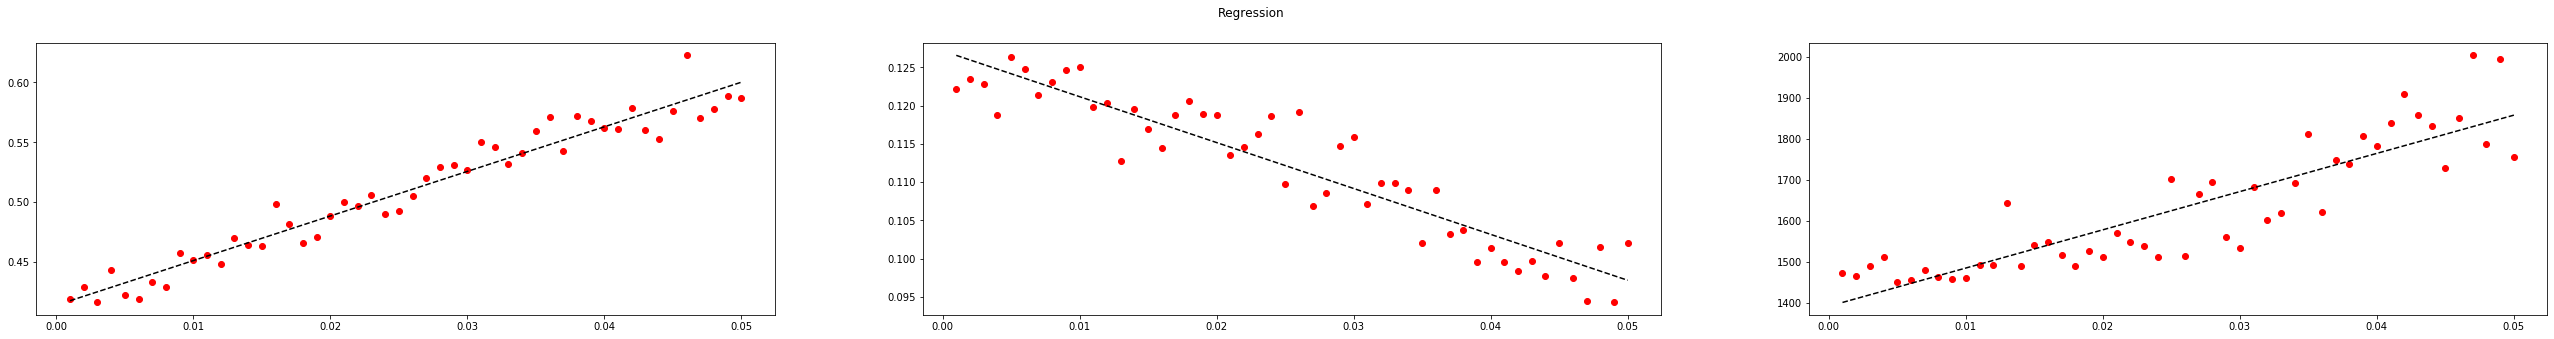

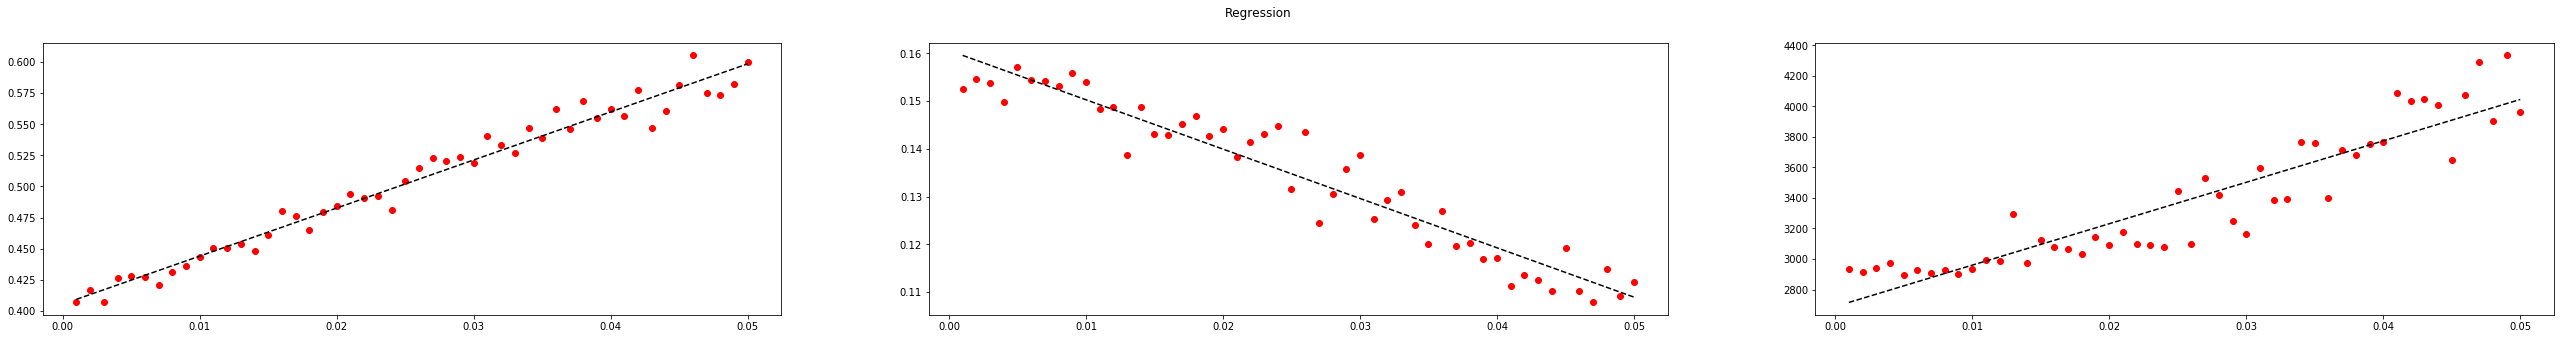

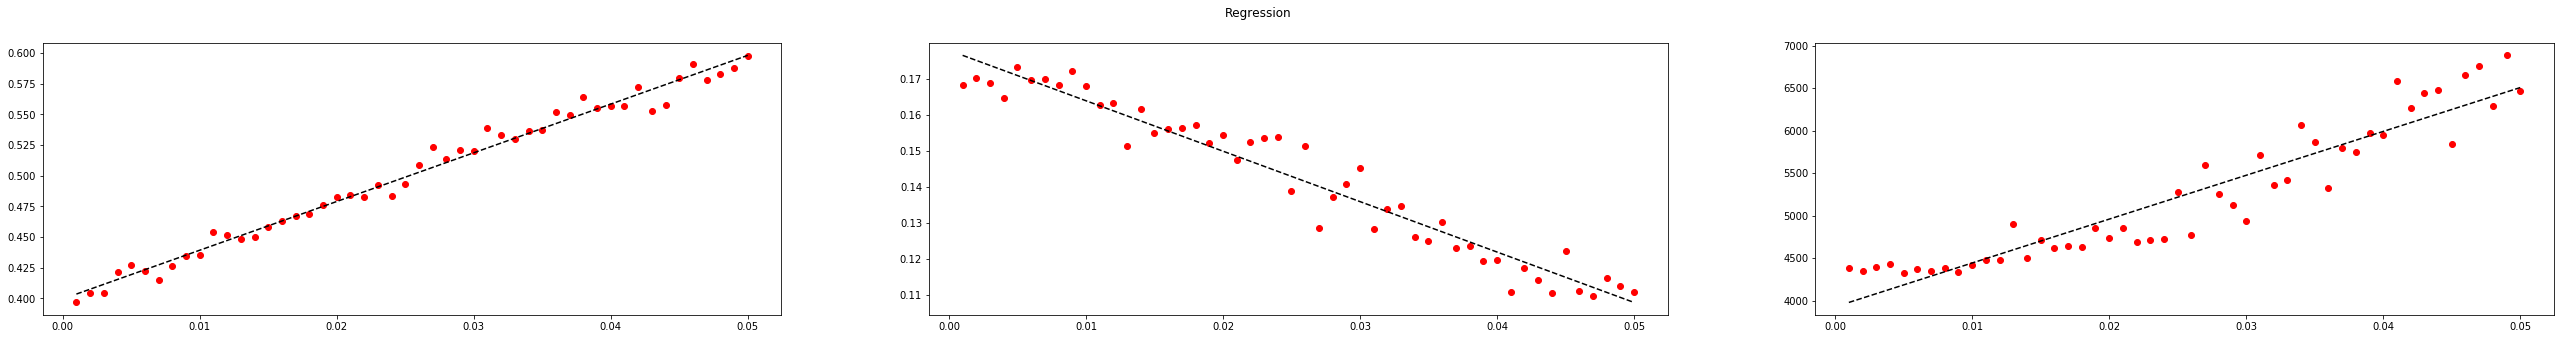

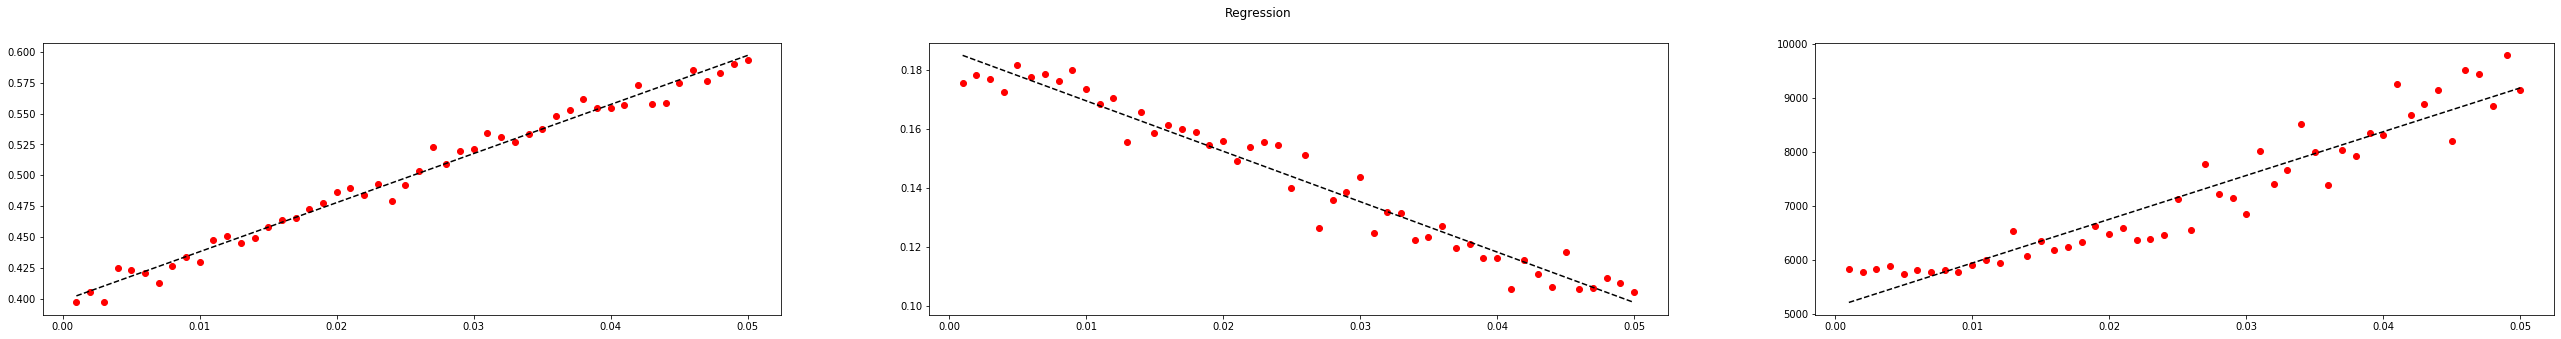

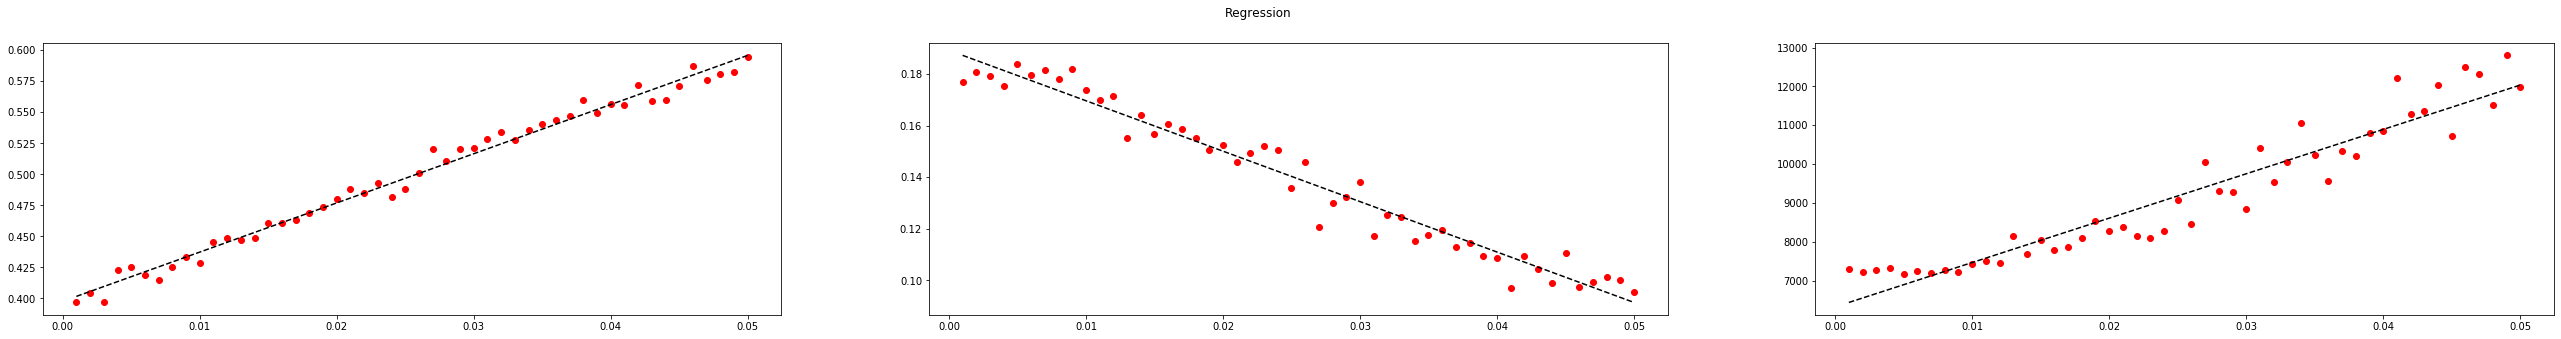

In [398]:
for k in [10000,20000,30000,40000,50000]:
    mat=getVariableMatrix(k)
    x=mat[:,3]
    y=mat[:,0]
    z=mat[:,1]
    mat[:,2]==mat[:,2]**0.5
    w=mat[:,2]
    #plt.plot(x,y)
    #plt.show()
    coef1 = np.polynomial.polynomial.polyfit(x,y,1)
    coef2 = np.polynomial.polynomial.polyfit(x,z,1)
    coef3 = np.polynomial.polynomial.polyfit(x,w,1)
    poly1d_fn = np.poly1d(coef) 
    ffit1 = np.polynomial.polynomial.Polynomial(coef1) 
    ffit2 = np.polynomial.polynomial.Polynomial(coef2)
    ffit3 = np.polynomial.polynomial.Polynomial(coef3)
    fig, (ax1, ax2,ax3) = plt.subplots(1,3,figsize=(45,5))
    fig.suptitle('Regression'+ str(k))
    ax1.plot(x,y, 'ro', x, ffit1(x), '--k')
    ax2.plot(x,z, 'ro', x, ffit2(x), '--k')
    ax3.plot(x,w, 'ro', x, ffit3(x), '--k')
    plt.show()

In [399]:
for k in [10000,20000,30000,40000,50000]:
    mat=getVariableMatrix(k)
    #print (np.corrcoef(mat[:,:3].T))
    model1 = sm.OLS(mat[:,3], sm.add_constant(mat[:,0])).fit()
    model2 = sm.OLS(mat[:,3], sm.add_constant(mat[:,1])).fit()
    model3 = sm.OLS(mat[:,3], sm.add_constant(mat[:,2])).fit()
    pca = PCA(n_components=1)
    X_train = pca.fit_transform(mat[:,:3])
    X_test = pca.transform(mat[:,:3])
    model4 = sm.OLS(mat[:,3], sm.add_constant(X_test)).fit()
    print (model1.rsquared,model2.rsquared,model3.rsquared,model4.rsquared)
    #print (model1.params,model2.params,model3.params,model4.params)

0.9463206425558632 0.8664503954662153 0.7782592003710755 0.7782592433442046
0.9716509484437549 0.9189052684830478 0.847276404399862 0.847276409183249
0.9840147110369305 0.941537725928706 0.8832171351518586 0.8832171363609217
0.9849261600348399 0.9538265401042976 0.8991435971890122 0.8991435976398356
0.9870673917576217 0.9595162247196999 0.908915243627725 0.908915243843862


In [400]:
###Analysis on N
mat=getCompleteMatrix()
mode = sm.OLS(mat[:,2], sm.add_constant(mat[:,:2])).fit()
print (mode.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.974
Model:                            OLS   Adj. R-squared:                  0.974
Method:                 Least Squares   F-statistic:                     4668.
Date:                Thu, 02 Jan 2020   Prob (F-statistic):          6.00e-197
Time:                        03:31:01   Log-Likelihood:                 1162.2
No. Observations:                 250   AIC:                            -2318.
Df Residuals:                     247   BIC:                            -2308.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1019      0.001    -74.757      0.0

In [404]:
mode.params

array([-1.01886800e-01,  2.49829228e-01,  6.19275008e-08])